In [1081]:
import os
import numpy as np
from osgeo import gdal, ogr, osr
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import shutil
import argparse
from rasterio.mask import mask
from utils_copy_Luca import plot_2dmatrix, my_mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
import skimage
from skimage.morphology import opening
from skimage.io import imsave
from skimage.morphology import square
from scipy.stats import pearsonr
from skimage import io

from coarse_census_CH_test import map_valid_ids_new



In [1082]:
pred_path = '/scratch3/viz/outputs/Switzerland_final_prediction_all_features/che_predicted_target_img.tiff'

val_path = '/scratch3/ldominiak/luca_pomelo_input_data/CHE/CHE_Census_Data/STATPOP_Census_2020_cleaned.tif'

In [1083]:
def get_swiss_mask(predicted_file, ground_truth_file):
    with rio.open(predicted_file) as pred_src:
        predicted_data = pred_src.read(1)
        predicted_meta = pred_src.meta
        predicted_nodata = pred_src.nodata

    with rio.open(ground_truth_file) as gt_src:
        ground_truth_data = gt_src.read(1)
        ground_truth_meta = gt_src.meta
        ground_truth_meta['nodata'] = predicted_nodata

    valid_data_mask = map_valid_ids_new

    plot_2dmatrix(valid_data_mask)

    # Handle nodata value
    if predicted_nodata is None:
        predicted_nodata = np.nan
    
    # Multiply with mask and preserve nodata values where the mask is False
    predicted_data_masked = np.where(valid_data_mask, predicted_data, predicted_nodata) * map_valid_ids_new
    ground_truth_data_masked = np.where(valid_data_mask, ground_truth_data, predicted_nodata) * map_valid_ids_new

    nan_mask = np.isnan(predicted_data_masked)

    # Flatten the array while excluding NaN values
    flattened_pred = predicted_data_masked[~nan_mask].flatten()
    flattened_gt= ground_truth_data_masked[~nan_mask].flatten()

    print(np.unique(flattened_pred), np.unique(flattened_gt))

    print(flattened_pred.shape, flattened_pred.shape)


    return flattened_pred, flattened_gt

In [1084]:
def get_regional_mask(predicted_file, ground_truth_file, regional_mask_file):
    with rio.open(predicted_file) as pred_src:
        predicted_data = pred_src.read(1)
        predicted_meta = pred_src.meta
        predicted_nodata = pred_src.nodata

    with rio.open(ground_truth_file) as gt_src:
        ground_truth_data = gt_src.read(1)
        ground_truth_meta = gt_src.meta
        ground_truth_meta['nodata'] = predicted_nodata

    with rio.open(regional_mask_file) as reg_src:
            # Read the pixel values
        image = reg_src.read(1)

        # Check the nodata value from the metadata
        nodata_value = reg_src.nodata

        # Create a boolean mask
        boolean_mask = (image == 1) & (image != nodata_value)
        print(np.unique(boolean_mask))
        plot_2dmatrix(boolean_mask)


    # Handle nodata value
    if predicted_nodata is None:
        predicted_nodata = np.nan

    predicted_data[~boolean_mask] = np.nan
    ground_truth_data[~boolean_mask] = np.nan


    flattened_pred = predicted_data[~np.isnan(predicted_data)].flatten()
    flattened_gt = ground_truth_data[~np.isnan(ground_truth_data)].flatten()

    print(np.unique(flattened_pred), np.unique(flattened_gt))

    print(flattened_pred.shape, flattened_gt.shape)

    return flattened_pred, flattened_gt


In [1085]:
def pixelwise_comparison_with_zeros(valid_predicted, valid_ground_truth):
    
    mape, _ = mean_absolute_percentage_error(valid_ground_truth, valid_predicted)

    # MAE (Mean Absolute Error) berechnen
    mae = mean_absolute_error(valid_ground_truth, valid_predicted)

    # MSE (Mean Squared Error) berechnen
    mse = mean_squared_error(valid_ground_truth, valid_predicted)

    # RMSE (Root Mean Squared Error) berechnen
    rmse = np.sqrt(mse)

    # R2-Score berechnen
    r2 = r2_score(valid_ground_truth, valid_predicted)

    print("MAPE:", mape)
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2-Score:", r2)

    print("Total Sum:", (valid_predicted.sum(), valid_ground_truth.sum()))
   
    return



[0.00000000e+00 1.10275097e-01 1.23130642e-01 ... 4.11494995e+02
 4.36418396e+02 4.53584717e+02] [0.00000000e+00 5.00002384e-01 5.00004888e-01 ... 1.10491418e+03
 1.36490112e+03 2.12127905e+03]
(6757238,) (6757238,)


<Figure size 432x288 with 0 Axes>

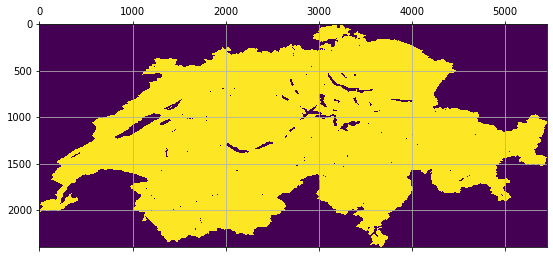

In [1086]:
swiss_masked_pred, swiss_masked_gt = get_swiss_mask(pred_path,val_path)

[False  True]
[  0.          2.9691634   3.0471222 ... 407.58075   411.495
 436.4184   ] [0.0000000e+00 5.0039905e-01 5.0267494e-01 ... 2.4910017e+02 7.2626733e+02
 8.8228632e+02]
(15180,) (15180,)
[False  True]
[  0.          3.8597143   3.9202344 ... 268.5893    312.70285
 357.0895   ] [0.0000000e+00 5.1409036e-01 5.6255567e-01 ... 1.1049142e+03 1.3649011e+03
 2.1212791e+03]
(2535,) (2535,)
[False  True]
[ 0.         2.1147366  2.1779356 ... 60.382797  61.937336  91.265656 ] [  0.          0.5005172   0.5033383 ... 125.98958   126.43133
 185.05302  ]
(2757,) (2757,)
[False  True]
[ 0.          0.12313064  0.18106373 ... 45.034557   47.333935
 58.238174  ] [ 0.         0.5009319  0.500947  ... 51.414757  54.405025  61.249043 ]
(74481,) (74481,)


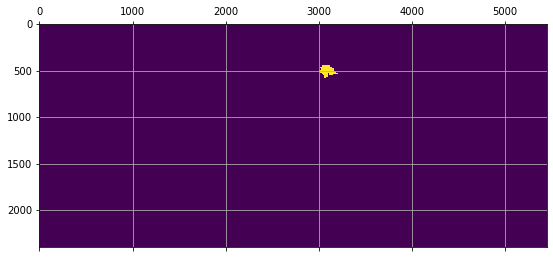

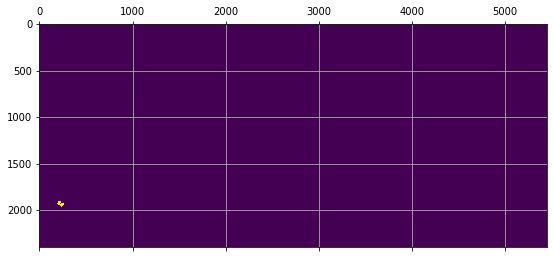

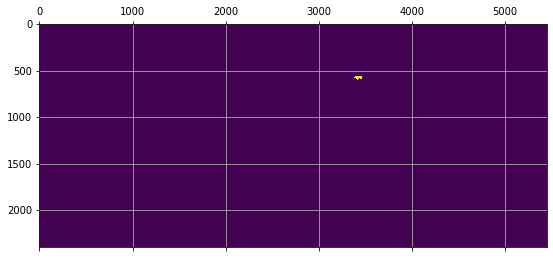

<Figure size 432x288 with 0 Axes>

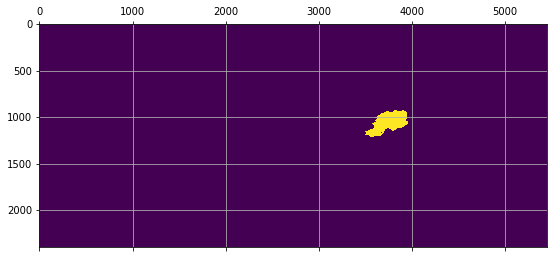

In [1087]:
zurich_pred, zurich_val = get_regional_mask(pred_path, val_path, '/scratch3/viz/outputs/Zurich_Region_mask.tif')
geneva_pred, geneva_val = get_regional_mask(pred_path, val_path, '/scratch3/viz/outputs/geneva_mask.tif')
wetzikon_pred, wetzikon_val = get_regional_mask(pred_path, val_path, '/scratch3/viz/outputs/Agglo_Wetzikon_mask.tif')
glarus_pred, glarus_val = get_regional_mask(pred_path, val_path, '/scratch3/viz/outputs/Peripherie_Glarus.tif')

In [1088]:

pixelwise_comparison_with_zeros(swiss_masked_pred, swiss_masked_gt)

MAPE: 104.9860599492598
MAE: 0.8810058171578284
MSE: 28.11243569915173
RMSE: 5.302116152929105
R2-Score: 0.4684563590060036
Total Sum: (7074140.292638876, 8716702.866822004)


In [1089]:

pixelwise_comparison_with_zeros(zurich_pred, zurich_val)

pixelwise_comparison_with_zeros(geneva_pred, geneva_val)

pixelwise_comparison_with_zeros(wetzikon_pred, wetzikon_val)

pixelwise_comparison_with_zeros(glarus_pred, glarus_val)

MAPE: 130.57098388671875
MAE: 17.077822
MSE: 1089.3191
RMSE: 33.004833
R2-Score: 0.2805020279940431
Total Sum: (313233.56, 426192.75)
MAPE: 137.6233696937561
MAE: 56.16748
MSE: 9142.033
RMSE: 95.61398
R2-Score: -0.03210408969858869
Total Sum: (79280.375, 195674.94)
MAPE: 123.63096475601196
MAE: 6.0700994
MSE: 209.84163
RMSE: 14.485911
R2-Score: 0.3611208401919124
Total Sum: (16736.992, 25239.924)
MAPE: 94.08715963363647
MAE: 0.10858313
MSE: 0.6583534
RMSE: 0.8113898
R2-Score: 0.6178978370150736
Total Sum: (11920.4795, 9864.271)


In [1090]:
def plot_scatter(true_values, predicted_values, labels):
    p1 = np.nanmax(np.concatenate(predicted_values + true_values))
    p2 = np.nanmin(np.concatenate(predicted_values + true_values))

    plt.figure(figsize=(10, 10))
    
    # Define custom colors for each region
    colors = ['crimson', 'navy', 'limegreen']
    
    # Iterate over each region
    for i, region in enumerate(true_values):
        true_value = true_values[i]
        predicted_value = predicted_values[i]
        label = labels[i]
        color = colors[i]
        
        # Plot the scatter with different colors for each region
        plt.scatter(true_value, predicted_value, c=color, alpha=0.7, label=label)
    
    plt.plot([1e-1, p1], [1e-1, p1], 'b-', linewidth=2, label='Regression Line')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis('equal')

    middle = (p1 + p2) / 2
    range_ = p1 - middle

    plt.xlim(max(1e-1, middle - range_), middle + range_)
    plt.ylim(max(1e-1, middle - range_), middle + range_)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right', fontsize=12)
    plt.title('Scatter Plot of Regional Predictions', fontsize=16)

    plt.show()

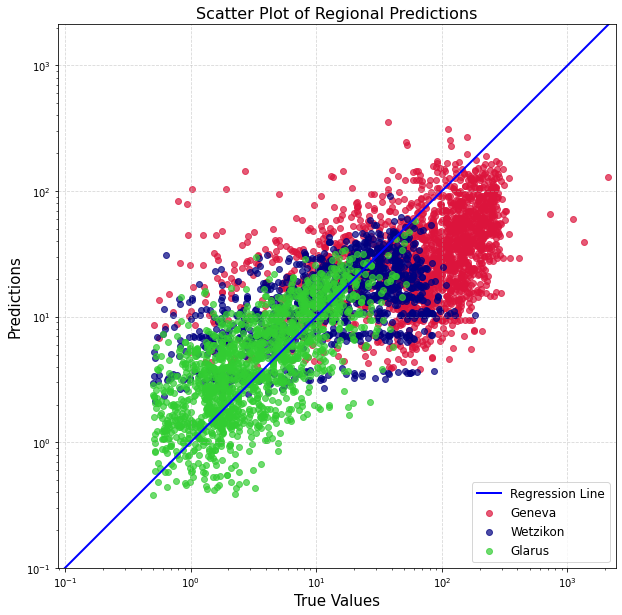

In [1091]:
true_values = [geneva_val, wetzikon_val, glarus_val]
predicted_values = [geneva_pred, wetzikon_pred, glarus_pred]
labels = ['Geneva', 'Wetzikon', 'Glarus']

# Call the plot_scatter function with the combined data
plot_scatter(true_values, predicted_values, labels)